In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import models
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import pandas as pd
from torchinfo import summary
from torchviz import make_dot
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from pythonlibs.torch_lib1 import *

plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = (6,6)
plt.rcParams['axes.grid'] = True
np.set_printoptions(suppress=True, precision=4)

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [6]:
# 分類先クラス名の定義

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# 分類先クラス数　今回は10になる
n_output = len(classes)

In [2]:
p = nn.AdaptiveAvgPool2d((1, 1))
print(p)

l1 = nn.Linear(32, 10)
print(l1)

AdaptiveAvgPool2d(output_size=(1, 1))
Linear(in_features=32, out_features=10, bias=True)


In [3]:
inputs = torch.randn(100, 32, 16, 16)
m1 = p(inputs)
m2 = m1.view(m1.shape[0], -1)
m3 = l1(m2)

print(m1.shape)
print(m2.shape)
print(m3.shape)

torch.Size([100, 32, 1, 1])
torch.Size([100, 32])
torch.Size([100, 10])


In [4]:
transform_train = transforms.Compose([
    transforms.Resize(112),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False),
])

transform = transforms.Compose([
    transforms.Resize(112),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
])

In [7]:
# データ取得用関数 Dataset

data_root = '../../data'

train_set = datasets.CIFAR10(
    root = data_root, train = True,
    download = True, transform = transform_train)

# 検証データの取得
test_set = datasets.CIFAR10(
    root = data_root, train = False, 
    download = True, transform = transform)

Files already downloaded and verified
Files already downloaded and verified


In [8]:
batch_size = 50
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [10]:
net = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/docker/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [11]:
print(net)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [20]:
net = net.to(device)
summary(net,(100, 3, 112, 112))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   --                        --
├─Conv2d: 1-1                            [100, 64, 56, 56]         9,408
├─BatchNorm2d: 1-2                       [100, 64, 56, 56]         128
├─ReLU: 1-3                              [100, 64, 56, 56]         --
├─MaxPool2d: 1-4                         [100, 64, 28, 28]         --
├─Sequential: 1-5                        [100, 64, 28, 28]         --
│    └─BasicBlock: 2-1                   [100, 64, 28, 28]         --
│    │    └─Conv2d: 3-1                  [100, 64, 28, 28]         36,864
│    │    └─BatchNorm2d: 3-2             [100, 64, 28, 28]         128
│    │    └─ReLU: 3-3                    [100, 64, 28, 28]         --
│    │    └─Conv2d: 3-4                  [100, 64, 28, 28]         36,864
│    │    └─BatchNorm2d: 3-5             [100, 64, 28, 28]         128
│    │    └─ReLU: 3-6                    [100, 64, 28, 28]         --
│

In [14]:
print(net.fc)
print(net.fc.in_features)

Linear(in_features=512, out_features=1000, bias=True)
512


In [17]:
torch_seed()

fc_in_features = net.fc.in_features
net.fc = nn.Linear(fc_in_features, n_output)

In [18]:
print(net)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

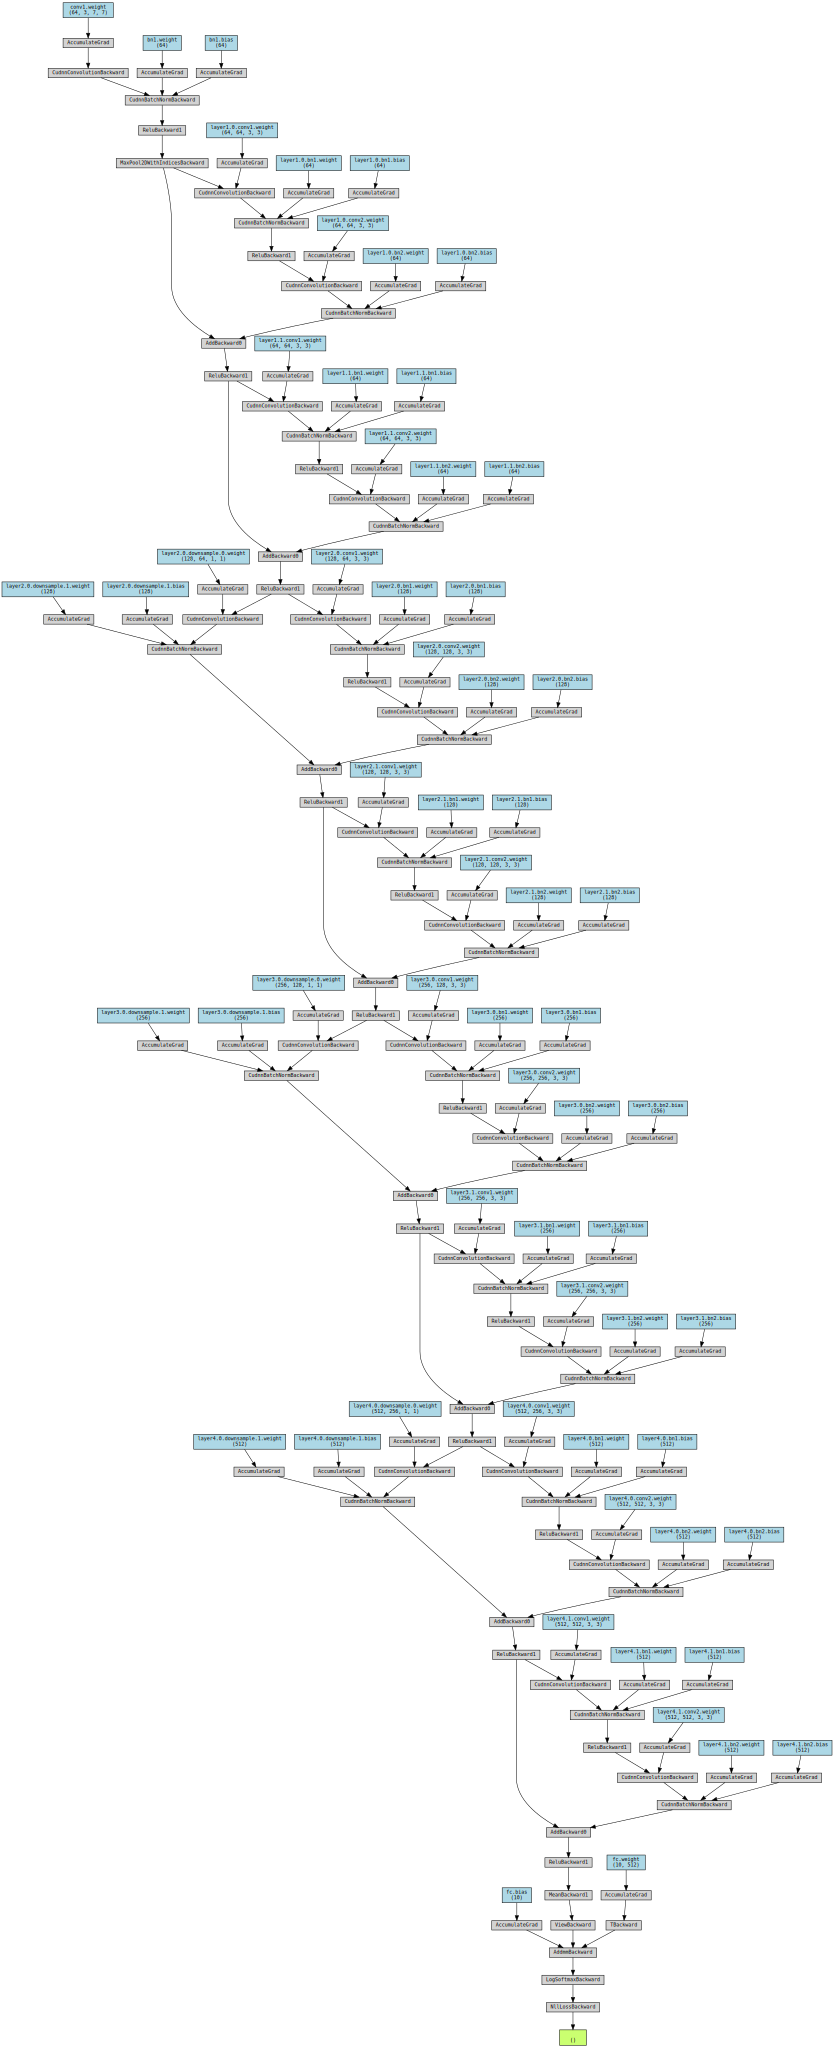

In [21]:
criterion = nn.CrossEntropyLoss()
loss = eval_loss(test_loader, device, net, criterion)
g = make_dot(loss, params=dict(net.named_parameters()))
display(g)

In [22]:
torch_seed()

net = models.resnet18(pretrained=True)

fc_in_features = net.fc.in_features
net.fc = nn.Linear(fc_in_features, n_output)
net = net.to(device)

lr = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)

history = np.zeros((0, 5))

In [23]:
num_epochs = 5
history = fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history)


Epoch [1/5], loss: 0.01223 acc: 0.79116 val_loss: 0.00528, val_acc: 0.90760



Epoch [2/5], loss: 0.00644 acc: 0.88812 val_loss: 0.00441, val_acc: 0.92470



Epoch [3/5], loss: 0.00520 acc: 0.91030 val_loss: 0.00393, val_acc: 0.93300



Epoch [4/5], loss: 0.00436 acc: 0.92454 val_loss: 0.00358, val_acc: 0.93830



Epoch [5/5], loss: 0.00376 acc: 0.93534 val_loss: 0.00358, val_acc: 0.94150


初期状態: 損失: 0.00528 精度: 0.90760
最終状態: 損失: 0.00358 精度: 0.94150


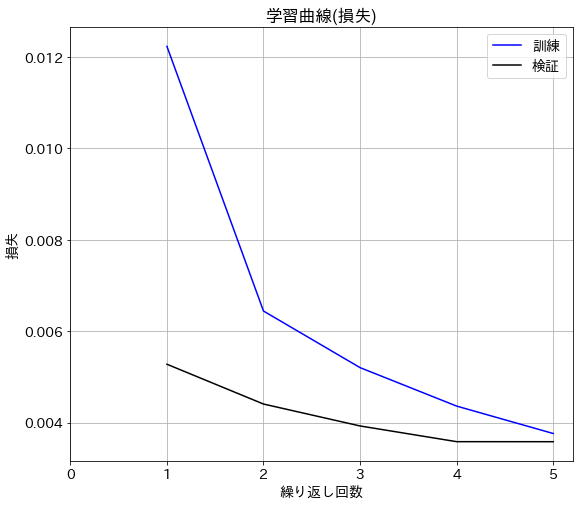

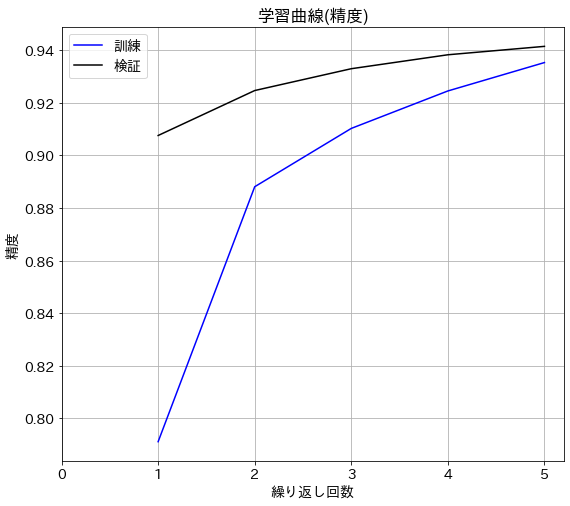

In [24]:
evaluate_history(history)

In [25]:
net = models.vgg19_bn(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /home/docker/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth


In [26]:
print(net)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [27]:
print(net.classifier[6])

Linear(in_features=4096, out_features=1000, bias=True)


In [28]:
torch_seed()

in_features = net.classifier[6].in_features
net.classifier[6] = nn.Linear(in_features, n_output)

net.features = net.features[:-1]
net.avg_pool = nn.Identity()

In [31]:
lr = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)

net = net.to(device)

history2 = np.zeros((0, 5))

In [32]:
num_epochs = 5
history2 = fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history2)


Epoch [1/5], loss: 0.00993 acc: 0.83368 val_loss: 0.00387, val_acc: 0.93490



Epoch [2/5], loss: 0.00485 acc: 0.91692 val_loss: 0.00304, val_acc: 0.94760



Epoch [3/5], loss: 0.00373 acc: 0.93682 val_loss: 0.00266, val_acc: 0.95460



Epoch [4/5], loss: 0.00310 acc: 0.94760 val_loss: 0.00255, val_acc: 0.95780



Epoch [5/5], loss: 0.00254 acc: 0.95750 val_loss: 0.00261, val_acc: 0.95810


初期状態: 損失: 0.00387 精度: 0.93490
最終状態: 損失: 0.00261 精度: 0.95810


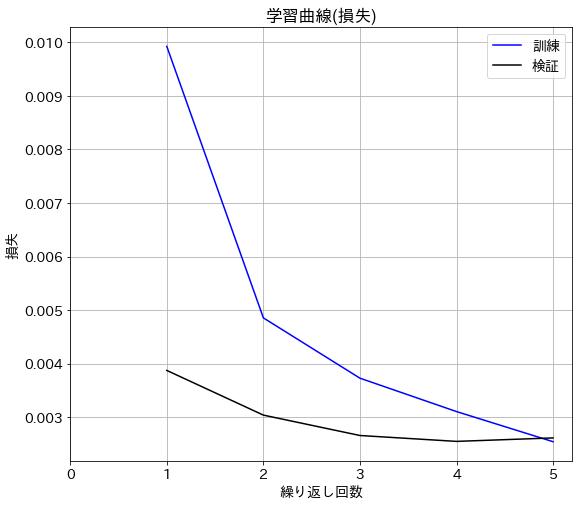

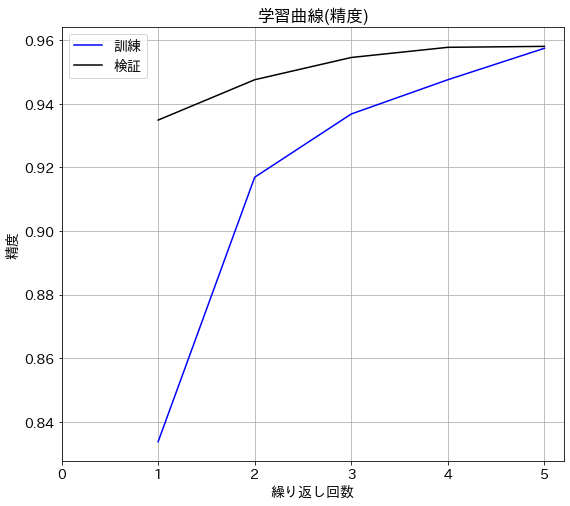

In [33]:
evaluate_history(history2)